
# <center>Car Recognize Bot</center>

In [3]:
!pip install pytorch_lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 585 kB 5.0 MB/s 
     |████████████████████████████████| 419 kB 62.5 MB/s 
     |████████████████████████████████| 140 kB 71.6 MB/s 
     |████████████████████████████████| 596 kB 59.4 MB/s 
     |████████████████████████████████| 1.1 MB 52.3 MB/s 
     |████████████████████████████████| 271 kB 60.5 MB/s 
     |████████████████████████████████| 94 kB 4.1 MB/s 
     |████████████████████████████████| 144 kB 76.7 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [4]:
!pip install mlflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 17.8 MB 1.0 MB/s 
     |████████████████████████████████| 181 kB 67.9 MB/s 
     |████████████████████████████████| 79 kB 9.1 MB/s 
     |████████████████████████████████| 146 kB 66.8 MB/s 
     |████████████████████████████████| 209 kB 52.2 MB/s 
     |████████████████████████████████| 81 kB 11.0 MB/s 
     |████████████████████████████████| 54 kB 1.7 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 
     |████████████████████████████████| 78 kB 7.7 MB/s 
  Created wheel for databricks-cli: filename=databricks_cli-0.17.0-py3-none-any.whl size=141960 sha256=dc600d602d1771879a477337913abc74733a4f4d706b66938d9cdcf19998a387
  Stored in directory: /root/.cache/pip/wheels/55/c3/db/33705569425fd2bdc9ea73051a8053fa26965c2bce8a146747
Successfully built databricks-cli


In [5]:
import os 
import glob
import PIL
import random
import cv2
import torch
import pandas as pd
import numpy as np
import pytorch_lightning as pl

import torch.nn as nn
from torchvision.models import resnet50
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.optim import SGD
from pytorch_lightning.loggers import MLFlowLogger
from torch.optim.lr_scheduler import ReduceLROnPlateau

import seaborn as sns
import matplotlib.pyplot as plt 

%matplotlib inline

## Connect to Google Drive

In [8]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Data Inspect

In [9]:
TRAIN_DIR = "/content/drive/MyDrive/Car-Recognize-Bot/car_data/train"
TEST_DIR = "/content/drive/MyDrive/Car-Recognize-Bot/car_data/test"
VALID_DIR = "/content/drive/MyDrive/Car-Recognize-Bot/car_data/valid"

In [10]:
train_car_dirs = sorted(
    glob.glob(os.path.join(TRAIN_DIR, "*"))
)
test_car_dirs = sorted(
    glob.glob(os.path.join(TEST_DIR, "*"))
)
valid_car_dirs = sorted(
    glob.glob(os.path.join(VALID_DIR, "*"))
)

In [11]:
all_train_images = 0

for car_dir in train_car_dirs:
    all_train_images += len(os.listdir(car_dir))

In [12]:
all_test_images = 0

for car_dir in test_car_dirs:
    all_test_images += len(os.listdir(car_dir))

In [13]:
all_valid_images = 0

for car_dir in valid_car_dirs:
    all_valid_images += len(os.listdir(car_dir))

In [14]:
print("All images for training: ", all_train_images) 
print("All images for validation: ", all_valid_images)
print("All images for test: ", all_test_images)

All images for training:  8091
All images for validation:  3977
All images for test:  4064


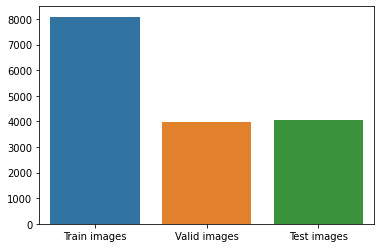

In [15]:
sns.barplot(x=['Train images', 'Valid images', 'Test images'], 
            y=[all_train_images, all_valid_images, all_test_images ])

## Pictures View

In [16]:
def match_label(labels):

    names = pd.read_csv("/content/drive/MyDrive/Car-Recognize-Bot/car_data/names.csv", header=None, names=['name']).reset_index()

    indexes = [names[names['name'] == label]['index'].to_numpy() for label in labels]

    return indexes

In [17]:
def images_and_labels(dir_path):
    car_dirs = sorted([os.path.join(dir_path, car_dir) for car_dir in os.listdir(dir_path)])

    images = []

    for car_dir in car_dirs:
        for image in os.listdir(car_dir):
            images.append(os.path.join(car_dir, image))

    values = [os.path.basename(os.path.dirname(item)) for item in images]

    labels = match_label(values)

    return images, labels

In [18]:
train_images, train_labels = images_and_labels(TRAIN_DIR)
valid_images, valid_labels = images_and_labels(VALID_DIR)
test_images, test_labels = images_and_labels(TEST_DIR)

In [19]:
names = pd.read_csv("/content/drive/MyDrive/Car-Recognize-Bot/car_data/names.csv", header=None, names=['name']).reset_index()

In [20]:
names.head()

,index,name
0,0,AM General Hummer SUV 2000
1,1,Acura RL Sedan 2012
2,2,Acura TL Sedan 2012
3,3,Acura TL Type-S 2008
4,4,Acura TSX Sedan 2012


In [21]:
def draw_image_with_label(images, labels):
  index = random.randint(0, len(images))

  title = names.iloc[train_labels[index][0]]['name']
  plt.title(title)

  image = cv2.imread(train_images[index])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  plt.imshow(image)

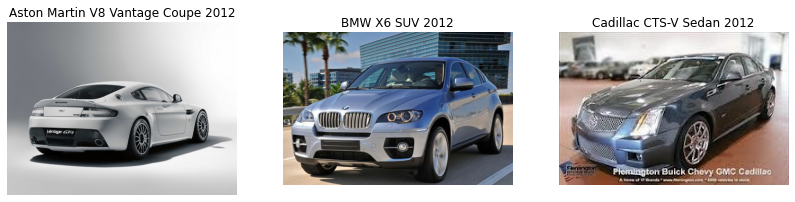

In [22]:
plt.figure(figsize=(14,8))

for i in range(1, 4):
  plt.subplot(1, 3, i)

  draw_image_with_label(train_images, train_labels)

  plt.axis('off');

## Dataloaders

In [23]:
def dataloader(dir_path: str, transforms, shuffle: bool = True):
    dataset = ImageFolder(root=dir_path, transform=transforms)

    return DataLoader(dataset, batch_size=32, shuffle=shuffle, num_workers=os.cpu_count())

## Transformers


In [24]:
train_transforms = transforms.Compose(
        [
            transforms.Resize((400, 400)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )

test_transforms = transforms.Compose(
    [
        transforms.Resize((400, 400)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

In [25]:
train_loader = dataloader(TRAIN_DIR, transforms=train_transforms)
valid_loader = dataloader(VALID_DIR, transforms=train_transforms)
test_loader = dataloader(TEST_DIR, transforms=test_transforms, shuffle=False)

## Model

In [26]:
class CarNet(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = resnet50(pretrained=True)
        self.num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(self.num_ftrs, 196)

        self.loss_function = nn.CrossEntropyLoss()
        self.losses = []

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, labels = batch
        output = self.forward(images)

        self.loss = self.loss_function(output, labels)
        self.losses.append(self.loss)

        return {"loss": self.loss}

    def get_callback_metrics(self) -> dict: 
        result = { 
            'loss': self.loss, 
        }
      
        return result 

    def configure_optimizers(self):
        optimizer = SGD(self.model.parameters(), lr=0.01, momentum=0.9)
        lrscheduler = ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)
        return {"optimizer": optimizer, "lr_scheduler": lrscheduler, "monitor": "loss"}


## Model Train

In [ ]:
# Model.
car_net = CarNet()

# Logger.
mlf_logger = MLFlowLogger(experiment_name="car-recognize", tracking_uri="file:./ml-runs")

# Trainer.
trainer = pl.Trainer(
    gpus=[0],
    max_epochs=10,
    logger=mlf_logger,
    enable_checkpointing=True,
    num_sanity_val_steps=1,
    log_every_n_steps=16,
)

# Model train.
trainer.fit(
    model=car_net,
    train_dataloaders=train_loader,
    val_dataloaders=valid_loader,
)

# Model test.
trainer.test(dataloaders=test_loader)

## Model Results

In [27]:
!pip install onnxruntime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.2 MB 5.1 MB/s 


In [28]:
import onnxruntime

In [29]:
loader = transforms.Compose([transforms.Resize((400, 400)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
image = Image.open(train_images[0])
image = loader(image).float()
image = torch.autograd.Variable(image, requires_grad=True)
image = image.unsqueeze(0)

In [30]:
def read_image(image: str):
    image = Image.open(image)
    train_transforms = transforms.Compose(
        [
            transforms.Resize((400, 400)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )

    return train_transforms(image).unsqueeze(0).numpy()


In [31]:
session = onnxruntime.InferenceSession("/content/drive/MyDrive/Car-Recognize-Bot/model.onnx")

In [32]:
index = random.randint(0, len(test_images))

In [33]:
image = read_image(test_images[index])

In [34]:
result = session.run(None, {'input': image})[0]

In [35]:
conf, predicted = torch.max(torch.from_numpy(result), 1)

In [36]:
ind = np.argpartition(result[0], -3)[-3:]
ind

array([148, 147, 146])

In [37]:
result[0][ind]

array([5.654342 , 6.461019 , 7.5156975], dtype=float32)

Jeep Liberty SUV 2012 confidence:  7.515697479248047
Jeep Liberty SUV 2012


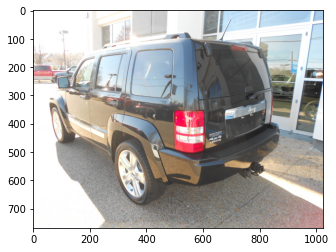

In [38]:
plt.imshow(Image.open(test_images[index]))
print(names.iloc[predicted.item()]['name'], "confidence: ", conf.item())
print(names.iloc[test_labels[index][0]]['name'])